# Grouping wells by water level patterns in the Treasure Valley

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr
VROOT = r'D:/TreasureValley/vadose'
warnings.filterwarnings('ignore')
#---------------------------
# Import nullset of TV wells, Data and site info
# ---------------------------
f = os.path.join(VROOT,'data/groundwater/null/WellInfo_null.csv')
#Read Wellsite
df = pd.read_pickle(os.path.join(VROOT,'data/groundwater/null/WellLevels_null.pkl'))
df[['StatusName','MethodName','AgencyName']] = df[['StatusName','MethodName','AgencyName']].astype(str)
arrays = [df.filter(regex=r'WellNum').values.squeeze(),df.filter(regex='Date').values.squeeze()]
idx = pd.MultiIndex.from_arrays(arrays,names=('WellNumber','TIMESTAMP'))
df.index = idx
del arrays, idx
df = df.pop('WaterLevelBelowLSD')
df = df.unstack( level = 0)
a = df.notnull().sum().sort_values()
wells = a[a >= 200].index
df = df.resample('MS').mean()
#df = df[df.notnull().any(axis=1)]
# Find long time series

## Transform data
f = lambda x: (x - x.mean()) / x.std()
data = df[wells].apply(f,axis=0)

## Correlation matrix of wells
Too noisy to visually make sense of antyhing

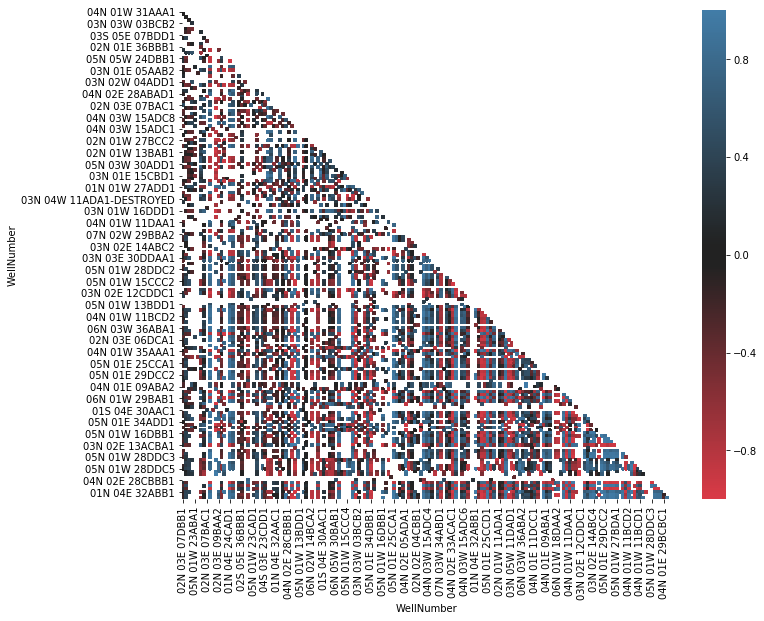

In [3]:
# Diagnoal Correlation Matrix
data_ma = data.groupby(data.index.month).mean().dropna(axis=1)
data_ma_corr = data_ma.corr(method='spearman',min_periods=7)  
## Mask for upper triangle
mask = np.zeros_like(data_ma_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
## Mask non- significant values

pvalmat = np.zeros((data_ma_corr.shape))
for i,well1 in enumerate(data_ma):
    for j,well2 in enumerate(data_ma):
        corrtest = pearsonr(data_ma[well1],data_ma[well2])
        pvalmat[i,j] = corrtest[1]
        
mask = mask + pvalmat > 0.05
## Sort by variance and plot
wells_by_var = data_ma.var().sort_values().index
f,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(10,240,as_cmap=True,center='dark')
sns.heatmap(data_ma_corr[wells_by_var], mask=mask, cmap =cmap,vmax = 1, vmin = -1, center = 0, square=True)

## Clustering techniques
I used to clustering libraries available in the Scikit Learn python library to make some groups of wells based on 
mean monthly levels for their period of record. Before clustering, I normalized the water level timeseries to have a unit variance and zero mean

In [4]:
# Dynamic Time Warping
def skclustsearch( data, n_neighbors,n_clusters ):
    
    from sklearn.metrics import calinski_harabaz_score, silhouette_score
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph

    #d=dict(list(zip(range(0,n_clust),plt.cm.tab10(range(0,n_clust)))))
    #d=dict(zip(range(0,6),['k','c','m','y','r','g']))
    f,ax = plt.subplots(2,5,figsize=(16,4.5),tight_layout=True)
    ax = ax.ravel()
    count = 0
    
    for neighbor in n_neighbors:
        knn_graph = kneighbors_graph(data.T,neighbor,include_self=False)
        for n_clust in n_clusters: 
            model = AgglomerativeClustering(linkage = 'ward',
                                            connectivity= knn_graph,
                                            n_clusters= n_clust)
            model.fit(data.T)
            # Compute metric scores
            ss = silhouette_score(data.T,model.labels_) #-1 bad cluster, 1 highly dense clustering, 0 overlapping
            chs = calinski_harabaz_score(data.T,model.labels_)
            #plt.rc('axes',prop_cycle=cycler('color',[d[l] for l in model.labels_]))
            temp=pd.DataFrame(data=data.values,
                              index=range(1,13),
                              columns= pd.MultiIndex.from_arrays(
                                      [data.columns, model.labels_],
                                      names=['WellNumber','cat']))
            catlist = temp.columns.tolist()a
            temp = temp.unstack().reset_index().rename(columns={0:'dtw','level_2':'month'})
            
            sns.tsplot(ax=ax[count],
                       legend=False,
                       data=temp,
                       time='month',
                       condition='cat',
                       value='dtw',
                       unit='WellNumber',
                       ci=[68,96])
            ax[count].set_xlabel('')
            ax[count].set_ylabel('')
            ax[count].set_title('nclust = {} neighbor = {}'.format(n_clust,neighbor),fontsize=9)
            del temp
            count += 1
    # Reset plot parameters
    #plt.rc(plt.rcParamsDefault)
    return 

def skclust(data,n_neighbors,n_clusters):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
   
    
    knn_graph = kneighbors_graph(data.T,n_neighbors,include_self=False)
    model = AgglomerativeClustering(linkage = 'ward',
                                            connectivity= knn_graph,
                                            n_clusters= n_clusters)
    model.fit(data.T)
    temp=pd.DataFrame(data=data.values,
                      index=range(1,13),
                      columns= pd.MultiIndex.from_arrays(
                              [data.columns, model.labels_],
                              names=['WellNumber','cat']))
    catlist = temp.columns.tolist()
    temp = temp.unstack().reset_index().rename(columns={0:'dtw','level_2':'month'})
    temp=temp.sort_values(by=['cat','WellNumber'])
    
    f,ax = plt.subplots(1,1,figsize=(4.5,4.5),tight_layout=True)  
    colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]        
    sns.tsplot(ax=ax,
               legend=True,
               data=temp,
               time='month',
               condition='cat',
               value='dtw',
               unit='WellNumber',
               ci=[68,96],
               color=sns.xkcd_palette(colors))
    ax.set_xlabel('Month')
    ax.set_ylabel('Normalized DTW')
    ax.set_title('nclust = {} neighbor = {}'.format(n_clusters,n_neighbors),fontsize=9)
    return {'model':model,'catlist':catlist}

## Clustering on normalized monthly water levels

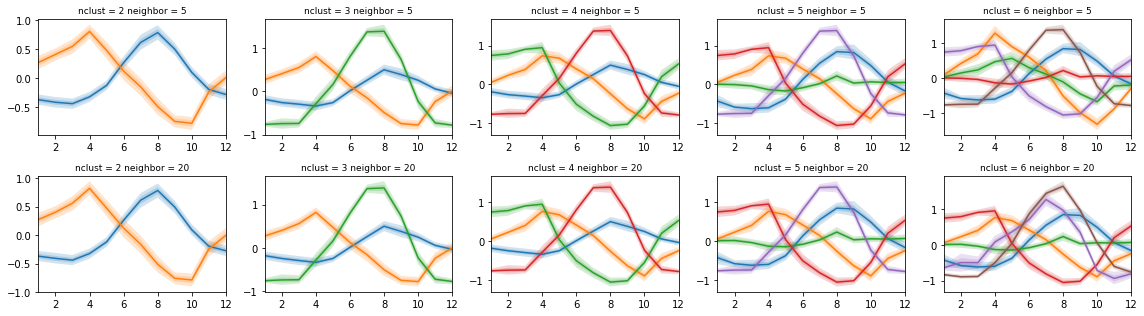

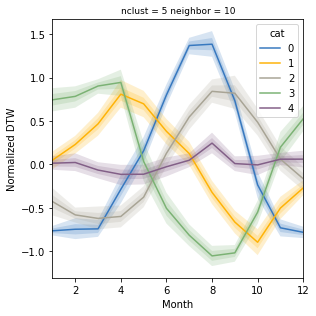

In [5]:
skclustsearch(data_ma,[5,20],[2,3,4,5,6])
d = skclust(data_ma,10,5)

# There doesn't seem to be a difference between the number of neighbors for the
# kneighbors array. variations around the mean and the normalized to unit variance
# plots parse out similar groups
cats = d['catlist']
catsdf = pd.DataFrame(index= [x[0] for x in cats],
                      data=[x[1] for x in cats],
                      columns=['group_5'])

The top graph shows the tweaking of desired clusters and a neighbor parameter for the Agglomerative Clustering. After 5 groups, the new groups seem to be very similar to existing groups. I went with five groups as shown in the second figure above. 

Based on nothing but the second figure, an interpretation could be:

+ 0 and 2: Influenced by pumping, group 0 more so than group 2. 
+ 1 and 3: shallower wells lower down in the valley in drains
+ 4: Deeper wells with larger storage?

In [17]:
data_ma.columns = pd.MultiIndex.from_tuples(cats,names=['WellNumber','group5'])
#data_ma.index = pd.MultiIndex.from_arrays(
#        [pd.period_range(start='2015-1-1',end='2015-12-31',freq='M').strftime('%b'),
#         ['W','W','Sp','Sp','Sp','Su','Su','Su','F','F','F','W']],names=['month','season'])
    

### Monthly waterlevel ranges by group

0         AxesSubplot(0.1,0.679412;0.363636x0.220588)
1    AxesSubplot(0.536364,0.679412;0.363636x0.220588)
2         AxesSubplot(0.1,0.414706;0.363636x0.220588)
3    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
4             AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

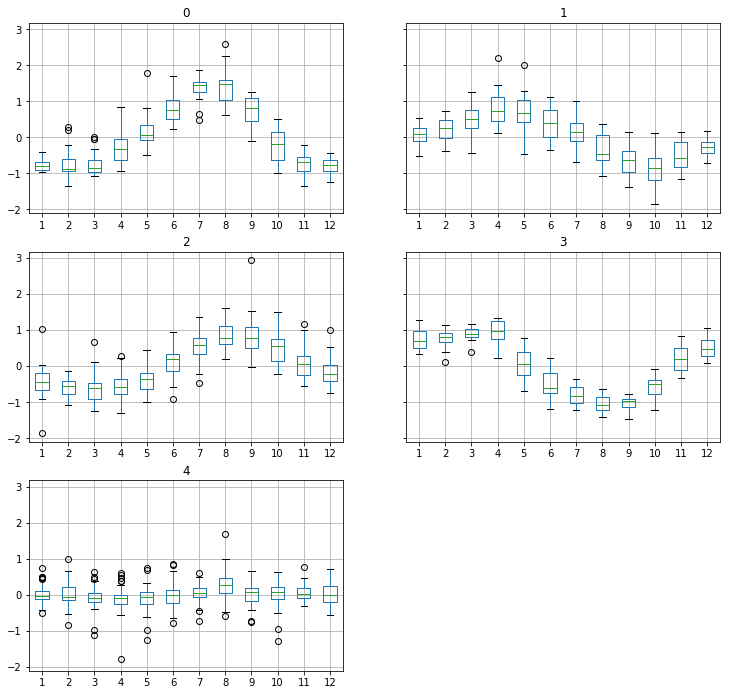

In [18]:
data_ma.T.groupby(data_ma.columns.get_level_values(1)).boxplot(figsize=(12,12))
# Box plot of Months across groups? So 12 subplots (3x4) with 5 boxes each

### Same thing but graphed by month looking at ranges between groups

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000108BBF28>,
      dtype=object)

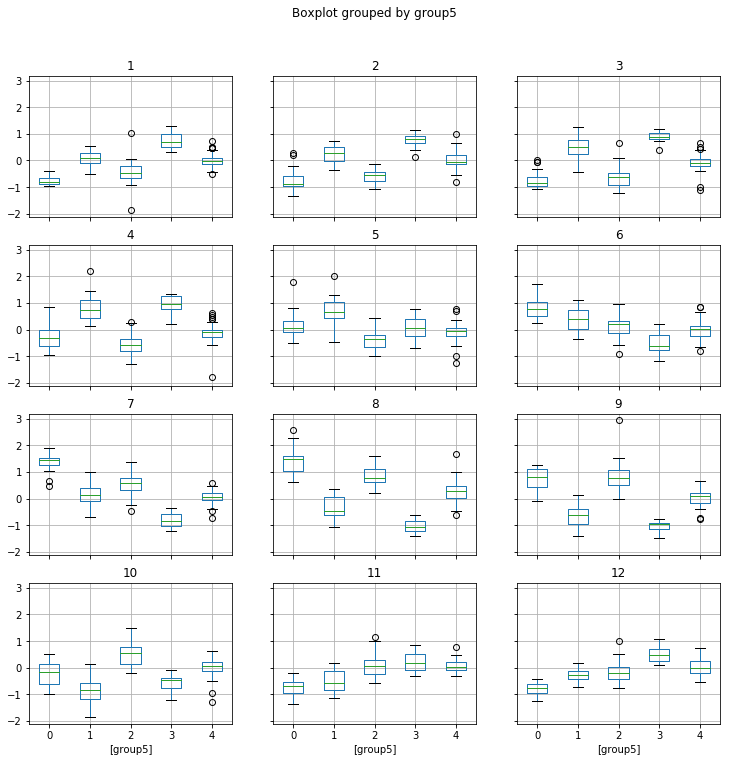

In [9]:
data_ma.T.boxplot(by='group5',figsize=(12,12))

### And here are the groups plotted against some well parameters
These are normalized to the given range of the parameters to make visualization easier

![title](group5_wellpars.png)

+ 1 and 3 are generally screened starting at shallower depths than other groups.
+ 1 and 3 are generally shallower than other groups
+ 0 is typically at lower elevations
+ 4 might be slightly higher in elevation

### Mapping the groups
Here is a map of the wells coded by group mapped across the valley. Sorry for the key, I could't get my GIS software to make a nice legend. Also it duplicated it, but the gist is that the groups are 0,1,2,3 and 4 as you move down the legend
![title](waterlevels_group5.png)

And to rehash my interpretations in terms of colors:
    
+ Blue and Green (0 and 2) were deeper during the growing season. Green was more delayed and decreased less than blue.
+ Red and Orange (1 and 3) were higher during the growing season with Red lagging behind Orange
+ Grey (4) decreased a little later in the growing season but did not have much variance

In [20]:
#---------------
# Spectrum stuff
# ----------------
# Get a few long time series from each group and plot a spectrogram or CWT or
# multitaper
#from matplotlib import gridspec
#gs = gridspec.GridSpec(2,5)

#fig, ax = plt.subplots(2,5,sharey = True,figsize=(19,19))
#ax = ax.ravel()


# for cat in range(0,5):
#     # Get wells in group
#     w = data_ma.T.groupby(level=1).get_group(cat).index.get_level_values(0)
#     # Extract longest timeseries from daily dataframe
#     dtw = df[w].resample('W').mean()
#     wellmax = dtw.notnull().sum().idxmax()
#     ts=dtw[wellmax].dropna().resample('W').mean()
#     ts=ts.interpolate(method='time')
#     ax1=plt.subplot(gs[0,cat])
#     ax1.plot(ts)
#     ax1.set_title('Group {} - {}'.format(cat,wellmax),fontsize=9)
#     dt = 1/52
#     ax2=plt.subplot(gs[1,cat])
#     ax2.psd(ts,2**8,1/dt)
#     ax2.set_xlabel(r'Frequency, $\frac{cycles}{yr}$')
#     # Write dataframe for export
#     if cat == 0:
#         temp = ts
#     else:
#         temp = pd.concat([temp,ts],axis=1)

